L'objectif de cette partie est d'extraire les zones à risques d'inodation à partir du fichier des Territoires à Risques important d'Inondation (TRI), millésime 2020 sous format shapefile, disponible au téléchargement au niveau national (première partie) puis régionale (deuxième partie) à l'adresse Url suivante : https://www.georisques.gouv.fr/donnees/bases-de-donnees/zonages-inondation-rapportage-2020

Ce fichier comprend les données d'inondabilité du territoire français identifiés par la directive Inondation à partir de 2007. 


In [7]:
# Importation du package Cartiflette 
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-lxblopyy
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-lxblopyy
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


CRS de gdf: EPSG:4326
CRS de france: EPSG:4326
Premier aperçu de joined:   typ_inond1 typ_inond2 scenario datfinval           id_tri  \
0         03         03     None       NaT  FRM_TRI_MAYOTTE   
1         02       None    01For       NaT     FRI_TRI_BASS   
2         02       None    01For       NaT     FRI_TRI_BASS   
3         02       None    02Moy       NaT     FRI_TRI_BASS   
4         02       None    02Moy       NaT     FRI_TRI_BASS   

              urlrapport  est_synth   datappro    id_carte    id  ...  \
0  N_MAYO_RISQUES_03.pdf          1 2019-12-16  CSI_030002  9794  ...   
1         non communiqué          0        NaT    CSI_1981  9835  ...   
2         non communiqué          0        NaT    CSI_1982  9836  ...   
3         non communiqué          0        NaT    CSI_1983  9837  ...   
4         non communiqué          0        NaT    CSI_1984  9838  ...   

  TDUU2017  AAV2020 TAAV2017  TDAAV2017 CATEAAV2020 BV2012  \
0      NaN      NaN      NaN        NaN        

/tmp/ipykernel_132431/1565626259.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
/tmp/ipykernel_132431/1565626259.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude


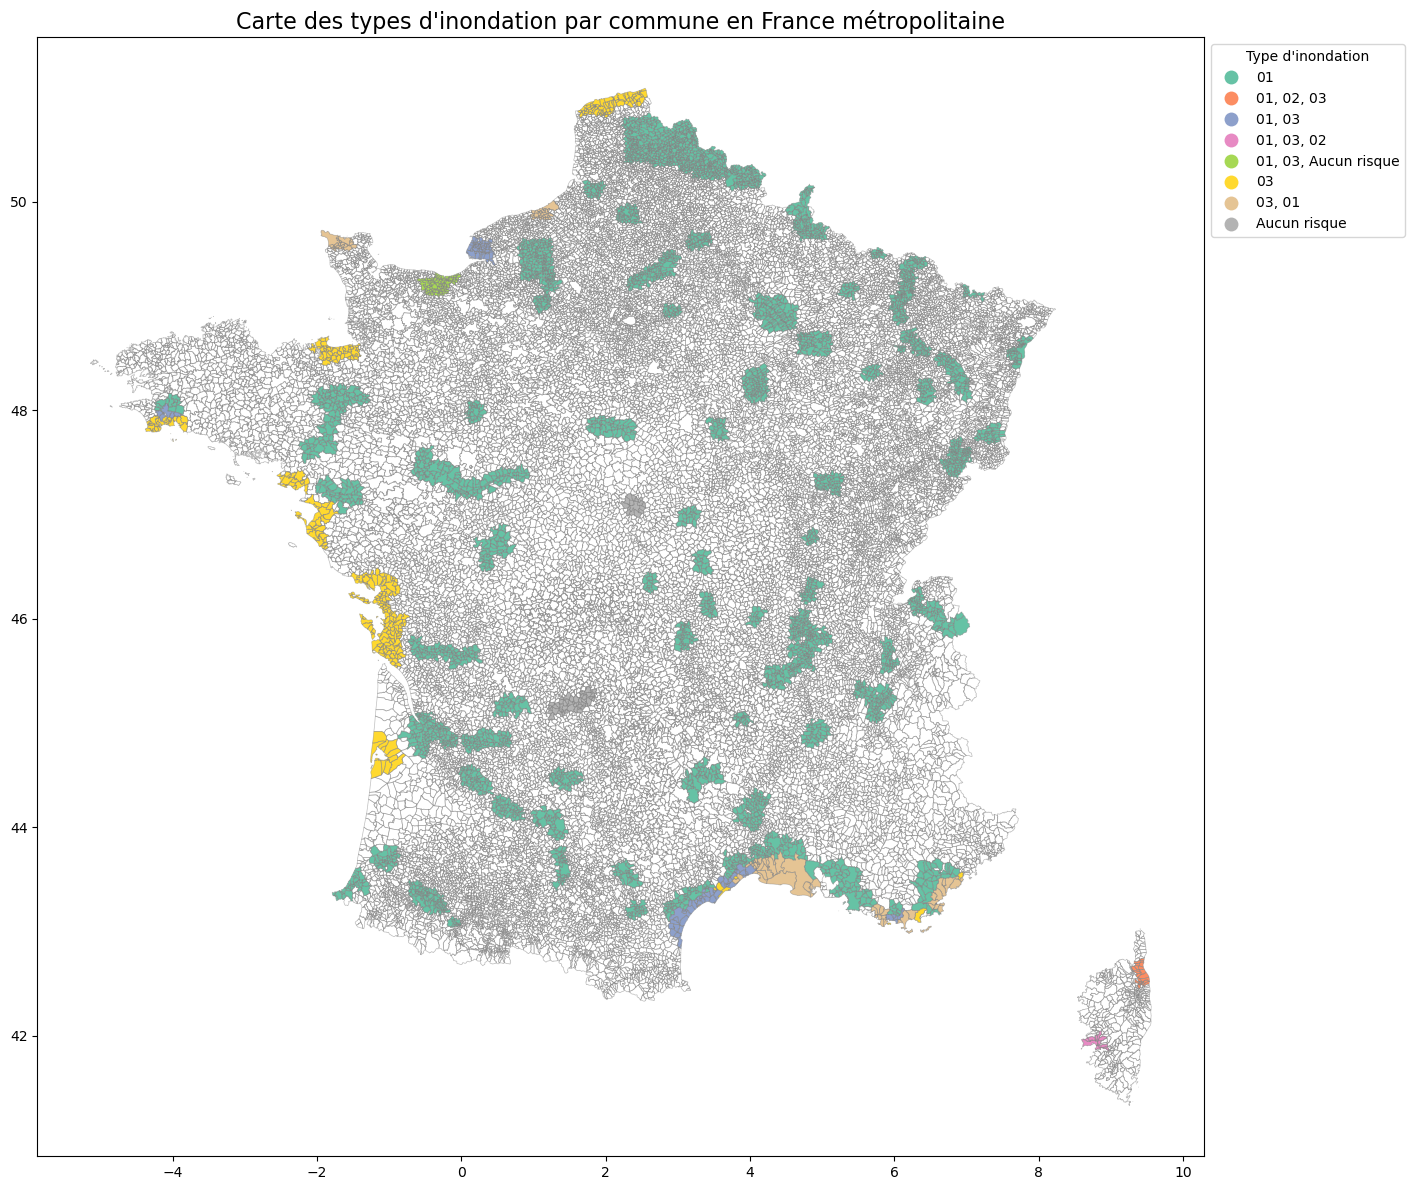

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)

# Vérification du CRS des deux jeux de données
print("CRS de gdf:", gdf.crs)
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
print("CRS de france:", france.crs)

# Filtrer les communes métropolitaines pour le fond de carte
france = france.loc[france["INSEE_REG"] > 10]

# Reprojeter 'france' pour qu'il corresponde à celui de 'gdf'
france = france.to_crs(gdf.crs)

# Effectuer une jointure spatiale entre les points du Shapefile et les communes
joined = gpd.sjoin(gdf, france, how="left", predicate="intersects")

# Vérification des résultats de la jointure
print("Premier aperçu de joined:", joined.head())

# Filtrer uniquement les communes de France métropolitaine
# En EPSG:2154, la latitude pour la France Métropolitaine est comprise entre 41 et 51, et la longitude entre -5 et 10.
gdf = gdf[
    (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
    (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude
]

# Remplacer les valeurs nulles dans 'typ_inond1' par "Aucun risque"
joined["typ_inond1"] = joined["typ_inond1"].fillna("Aucun risque")  # Replace NaN with "Aucun risque"

# Agréger les risques pour chaque commune en combinant tous unique risks
joined["typ_inond1"] = joined["typ_inond1"].astype(str)  # Convert to string for categorical handling
commune_risks = joined.groupby("INSEE_COM")["typ_inond1"].apply(lambda x: ', '.join(x.unique())).reset_index()

# Ajouter les risques au fond de carte
france = france.merge(commune_risks, on="INSEE_COM", how="left")

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes
france.boundary.plot(ax=ax, linewidth=0.5, color="gray", alpha=0.5)

# Remplir les communes avec les risques associés (Categorical colormap)
france.plot(
    column="typ_inond1",
    ax=ax,
    legend=True,
    cmap="Set2",  # Utilisation d'une colormap catégorielle
    legend_kwds={
        "title": "Type d'inondation",
        "loc": "upper left",
        "bbox_to_anchor": (1, 1),
    },
)

# Ajouter un titre
ax.set_title("Carte des types d'inondation par commune en France métropolitaine", fontsize=16)

plt.tight_layout()
plt.show()

In [17]:
gdf

typ_inond1 typ_inond2 scenario  datfinval  \
12           01       None    01For        NaT   
13           01       None    01For        NaT   
14           01       None    01For        NaT   
15           01       None    04Fai        NaT   
16           01       None     None 2019-12-20   
...         ...        ...      ...        ...   
3663         01       None    01For        NaT   
3664         01       None    02Moy        NaT   
3665         01       None    02Moy        NaT   
3666         01       None    02Moy        NaT   
3667         01       None    02Moy        NaT   

                                     id_tri  \
12    FRC_TRI_AGGLOMERATION_STRASBOURGEOISE   
13    FRC_TRI_AGGLOMERATION_STRASBOURGEOISE   
14    FRC_TRI_AGGLOMERATION_STRASBOURGEOISE   
15    FRC_TRI_AGGLOMERATION_STRASBOURGEOISE   
16             FRH_TRI_CHALONS_EN_CHAMPAGNE   
...                                     ...   
3663                          FRH_TRI_CREIL   
3664                          FRH_TRI_CREIL   
3665                          FRH_TRI_CREIL   
3666                          FRH_TRI_CREIL   
3667                          FRH_TRI_CREIL   

                                             urlrapport  est_synth   datappro  \
12    http://www.lorraine.developpement-durable.gouv...          0        NaT   
13    http://www.lorraine.developpement-durable.gouv...          0        NaT   
14    http://www.lorraine.developpement-durable.gouv...          0        NaT   
15    http://www.lorraine.developpement-durable.gouv...          0        NaT   
16    http://www.champagne-ardenne.developpement-dur...          1 2013-12-20   
...                                                 ...        ...        ...   
3663  http://www.picardie.developpement-durable.gouv...          0 2013-12-20   
3664  http://www.picardie.developpement-durable.gouv...          0 2013-12-20   
3665  http://www.picardie.developpement-durable.gouv...          0 2013-12-20   
3666  http://www.picardie.developpement-durable.gouv...          0 2013-12-20   
3667  http://www.picardie.developpement-durable.gouv...          0 2013-12-20   

      id_carte       id                                           geometry  
12       CSI_1    10102  POLYGON ((7.56731 48.52208, 7.5723 48.57919, 7...  
13       CSI_4    10103  POLYGON ((7.67892 48.48876, 7.68402 48.54586, ...  
14       CSI_2    10104  POLYGON ((7.63114 48.53212, 7.6362 48.58924, 7...  
15      CSI_21    10122  POLYGON ((7.79023 48.63316, 7.79547 48.69026, ...  
16    CSI_1495    10123  POLYGON ((4.09496 49.07604, 4.49757 49.0717, 4...  
...        ...      ...                                                ...  
3663     CSI_4  2002831  POLYGON ((2.55934 49.25914, 2.55856 49.35036, ...  
3664     CSI_5  2002832  POLYGON ((2.32552 49.17737, 2.32432 49.26899, ...  
3665     CSI_6  2002833  POLYGON ((2.39823 49.20089, 2.39716 49.29239, ...  
3666     CSI_7  2002834  POLYGON ((2.47588 49.22869, 2.47495 49.32005, ...  
3667     CSI_8  2002835  POLYGON ((2.55934 49.25914, 2.55856 49.35036, ...  

[3258 rows x 11 columns]

Voici une première représentation des risques  d'inondation présents sur le territoire métropolitain Français. 

l'échelle de risque des fichiers Shapefile de georisques est construite selon l'échelle suivante : 
- 1 : Risque faible
- 2 : Risque Modéré 
- 3 : Risque fort 

Nous pouvons remarquer de prime abord que les zones à risque fort d'inondation sont concentrées sur les littoraux. 

Dans cette représentation, nous avons conservé l'intégralité des risques présents à l'intérieur d'une commune. 

La prochaine représentation s'intéresse au risque maximal pour chaque points géographiques présent sur la commune : 

/tmp/ipykernel_132431/975786343.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
/tmp/ipykernel_132431/975786343.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude


Valeurs uniques dans 'typ_inond1': [1 3 0 2]


/tmp/ipykernel_132431/975786343.py:66: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  choropleth = france_with_data.plot(


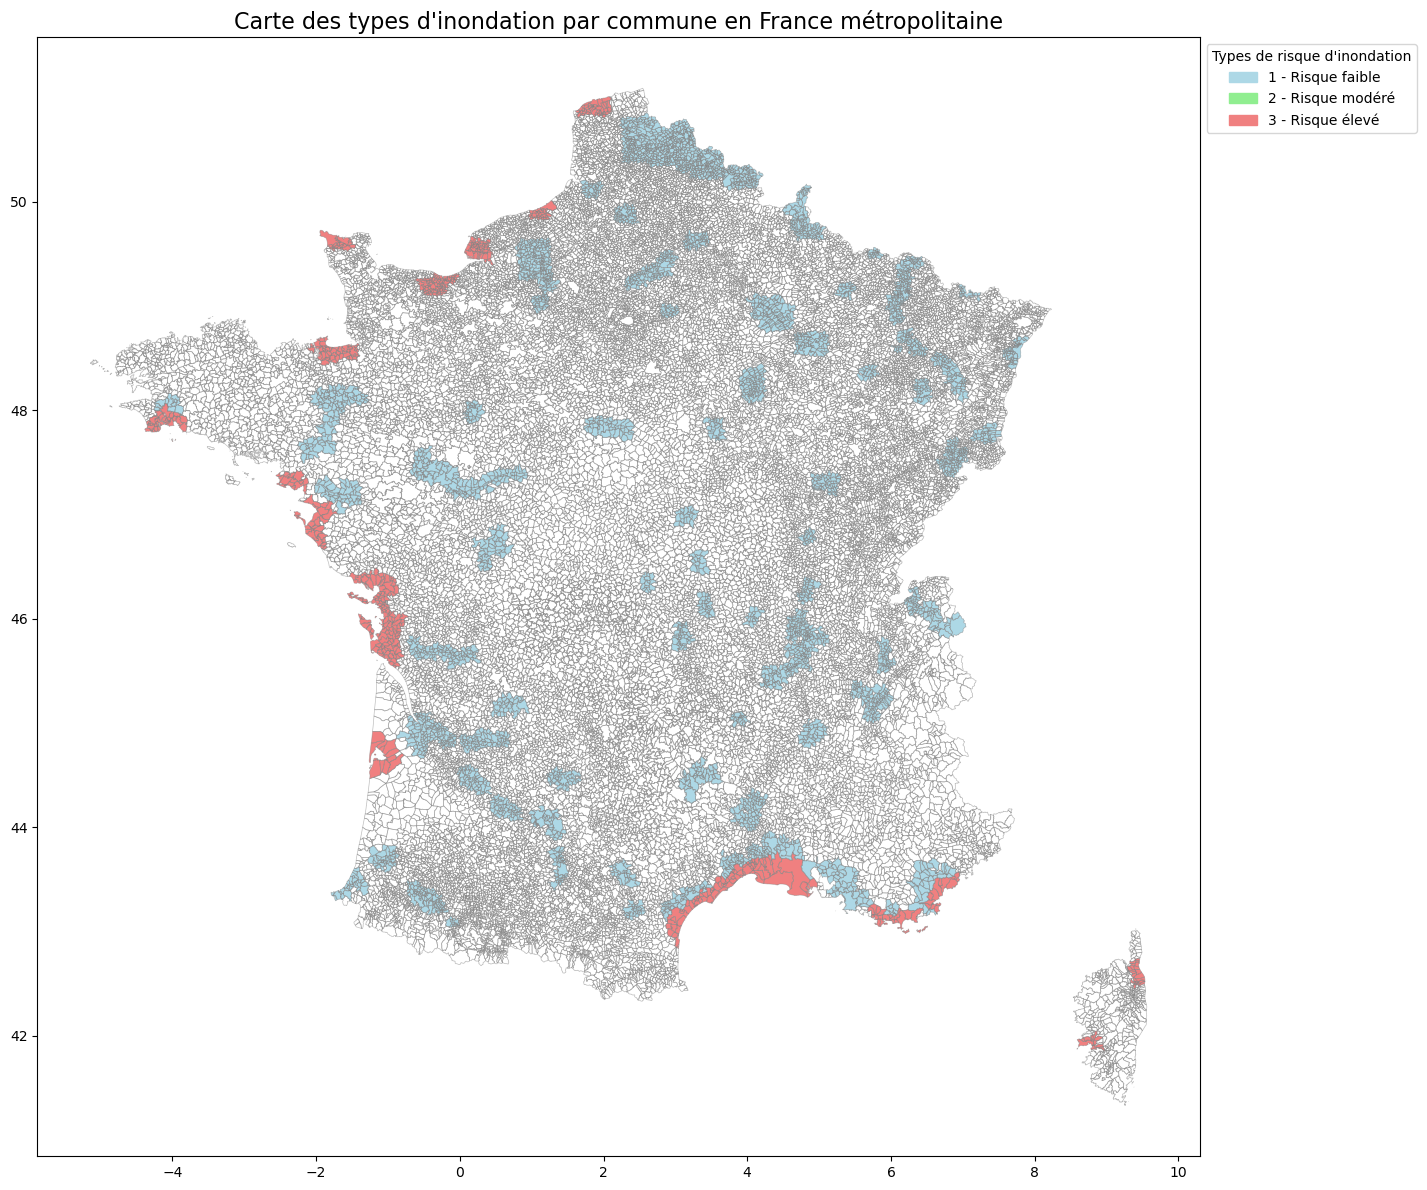

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download
import matplotlib.patches as mpatches

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)

# Filtrer pour garder uniquement les points en France métropolitaine
gdf = gdf[
    (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
    (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude
]

# Télécharger le fond de carte via Cartiflette
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Filtrer les communes métropolitaines pour le fond de carte
france = france.loc[france["INSEE_REG"] > 10]

# Vérifier et aligner les CRS
if gdf.crs != france.crs:
    gdf = gdf.to_crs(france.crs)

# Effectuer une jointure spatiale entre les points du Shapefile et les communes
joined = gpd.sjoin(gdf, france, how="left", predicate="intersects")

# Remplacer les valeurs nulles dans 'typ_inond1' par 0 (Aucun risque)
joined["typ_inond1"] = joined["typ_inond1"].fillna(0).astype(int)

# Vérification des valeurs uniques dans 'typ_inond1'
print("Valeurs uniques dans 'typ_inond1':", joined["typ_inond1"].unique())

# Agréger les risques pour chaque commune en combinant tous unique risks
max_risks = joined.groupby("INSEE_COM")["typ_inond1"].max().reset_index()

# Ajouter les risques au fond de carte
france = france.merge(max_risks, on="INSEE_COM", how="left")

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes
france.boundary.plot(ax=ax, linewidth=0.5, color="gray", alpha=0.5)

# Définir une palette de couleurs pour 0, 1, 2 et 3
color_map = {0: None, 1: "lightblue", 2: "lightgreen", 3: "lightcoral"}

# Appliquer les couleurs, et laisser transparent (None) pour les zones sans données
france["color"] = france["typ_inond1"].map(color_map)

# Supprimer les communes sans couleur (pas de données)
france_with_data = france[france["color"].notna()]

# Remplir les communes avec les risques associés
choropleth = france_with_data.plot(
    column="typ_inond1",  # Utiliser les risques d'inondation
    ax=ax,
    color=france_with_data["color"],  # Appliquer la couleur selon la colonne 'color'
    legend=False  # Désactiver la génération automatique de la légende
)

# Ajouter un titre
ax.set_title("Carte des types d'inondation par commune en France métropolitaine", fontsize=16)

# Ajouter manuellement la légende avec matplotlib
legend_labels = ['1 - Risque faible', '2 - Risque modéré', '3 - Risque élevé']
legend_colors = ['lightblue', 'lightgreen', 'lightcoral']

# Créer une légende manuellement avec les couleurs correspondantes
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
ax.legend(handles=patches, title="Types de risque d'inondation", loc='upper left', bbox_to_anchor=(1, 1))

# Ajuster l'espacement et afficher la carte
plt.tight_layout()
plt.show()


Notre intuition concernant la répartition des risques entre littoral et l'intérieur du pays est confortée. 

On Pourrait s'intéresser au croisement entre nature du risque et niveau de risque. 

Nous allons nous concentrer sur une zone où il semblerait y avoir une forte corrélation, d'après le papier de Tristan Ancel et Thierry Kamionka, entre les effets du risque d'inondation et la valeur foncière: le Gard. 
Dans leur article, Les effets du risque d’inondation sur la valeur foncière des maisons en France, Les auteurs mettent en évidence une décote proportionnelle au risque dans le Gard que nous tenterons également à partir de nos jeux de données de mettre en évidence. 


I- Analyse granulaire du risque d'inondation dans le Gard 

a- analyse du fichier shapefile TRI de Nimes

Le département du Gard a un antécédent historique avec les inondations comme en témoigne son record national anodin de pluviométrie avec 950 mm en 24 heures à Valleraugue en 1907. Les inondations gardoises sont de différentes natures et niveau, que nous cherchons à mettre en évidence dans cette partie à partir des deux bases de données disponibles sur georisques = 
- Zonage Inondation - Rapportage 2020
- API TRI : Opérations sur les Territoires à Risques importants d'Inondation (TRI) 

Les données du Zonage Inondation sont disponibles à l'échelle départementale, ce qui nous interesse dans notre ciblage sur le Gard. Les fichiers Shapefiles contenant la classification des zones à risques d'inondation par segment géographique sont regroupés autour de 5 zones du Gard : 
- Ales 
- Avignon
- Delta
- Montpellier 
- Nimes 
que nous avons telechargés et retrouvables au chemin suivant : Shapefile processing/Shp file : Zones innondables 

Nous avons également téléchargés la BDCarthage qui recense l'ensemble des cours d'eaux pour la région Occitanie afin d'associer la présence de cours d'eau à la nature du risque d'inondation (Par exemple : Les inondations de plaine se produisent lorsqu'une rivière sort lentement de son lit). 

/tmp/ipykernel_132431/311207542.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  Gard_filtered = Gard[Gard.intersects(gdf.unary_union)]


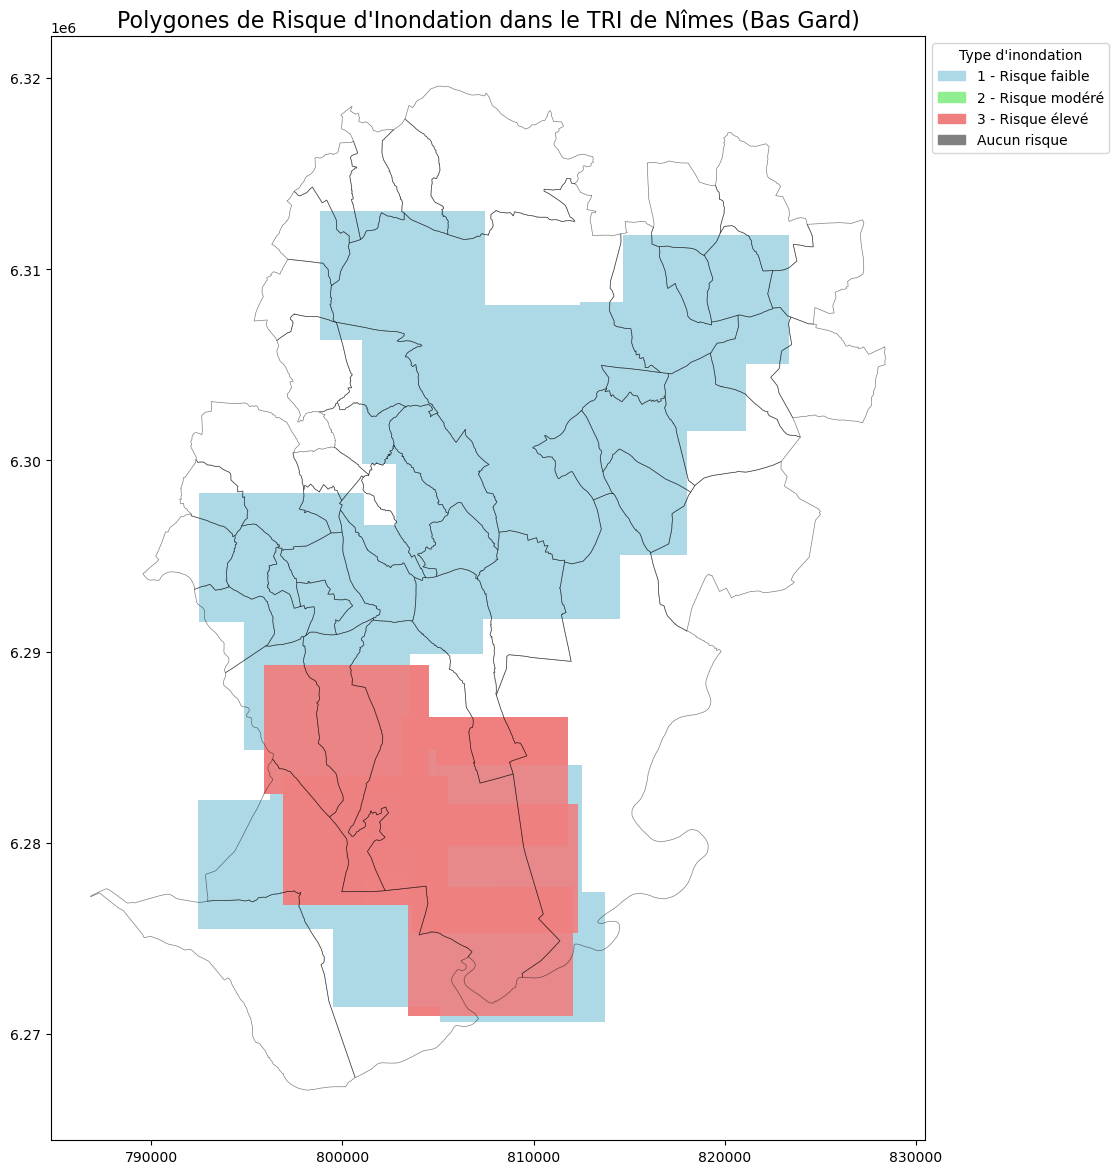

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download
import matplotlib.patches as mpatches

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_tri_nimes_carte_inond_s_030.shp"
gdf = gpd.read_file(shapefile_path)

# Reprojeter les géométries en un CRS projeté (ici, EPSG:2154 pour la France)
gdf = gdf.to_crs(epsg=2154)

# Télécharger le fond de carte Cartiflette pour le Gard
Gard = carti_download(
    crs=4326,
    values="30",
    borders="COMMUNE",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Reprojeter 'Gard' pour qu'il corresponde à celui de 'gdf'
Gard = Gard.to_crs(gdf.crs)

# Filtrer les communes du Gard pour ne garder que celles intersectant les polygones de 'gdf'
Gard_filtered = Gard[Gard.intersects(gdf.unary_union)]

# Effectuer une jointure spatiale entre le Shapefile et les communes filtrées
joined = gpd.sjoin(gdf, Gard_filtered, how="left", predicate="intersects")

# Créer un dictionnaire de couleurs pour chaque type d'inondation
color_map = {
    "01": "lightblue",   # Exemple de couleur pour Risque faible
    "02": "lightgreen",  # Exemple de couleur pour Risque modéré
    "03": "lightcoral",  # Exemple de couleur pour Risque élevé
    "00": "gray"         # Couleur pour "Aucun risque"
}

# Ajouter une colonne 'color' au DataFrame 'joined' pour assigner la couleur à chaque polygone
joined['color'] = joined['typ_inond1'].map(color_map)

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes filtrées (seulement celles du bas Gard)
Gard_filtered.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.5)

# Afficher les polygones de 'gdf' sur la carte avec la couleur associée à chaque type d'inondation
joined.plot(ax=ax, color=joined['color'], alpha=0.5)

# Ajouter un titre
ax.set_title("Risque d'Inondation dans le TRI de Nîmes", fontsize=16)

# Ajouter une légende pour les types de risque
legend_labels = ['1 - Risque faible', '2 - Risque modéré', '3 - Risque élevé', 'Aucun risque']
legend_colors = ['lightblue', 'lightgreen', 'lightcoral', 'gray']

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
ax.legend(handles=patches, title="Type d'inondation", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


/tmp/ipykernel_132431/2177854936.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  Gard_filtered = Gard[Gard.intersects(gdf.unary_union)]
/tmp/ipykernel_132431/2177854936.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  waterways_filtered = waterways[waterways.intersects(Gard_filtered.unary_union)]


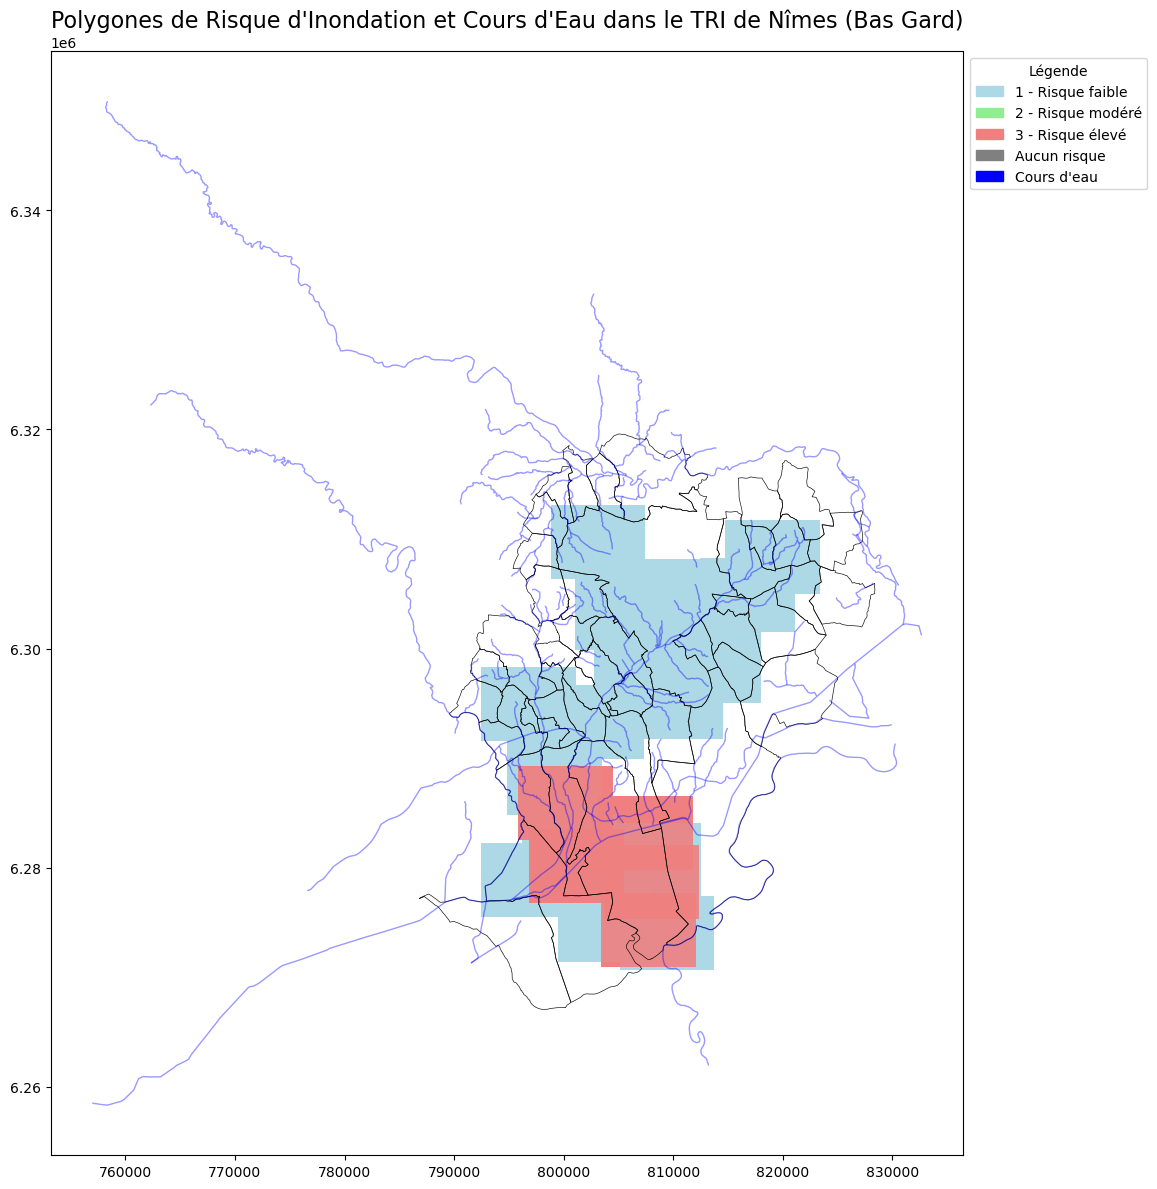

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download
import matplotlib.patches as mpatches

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_tri_nimes_carte_inond_s_030.shp"
gdf = gpd.read_file(shapefile_path)

# Reprojeter les géométries en un CRS projeté (ici, EPSG:2154 pour la France)
gdf = gdf.to_crs(epsg=2154)

# Télécharger le fond de carte Cartiflette pour le Gard
Gard = carti_download(
    crs=4326,
    values="30",
    borders="COMMUNE",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Reprojeter 'Gard' pour qu'il corresponde à celui de 'gdf'
Gard = Gard.to_crs(gdf.crs)

# Filtrer les communes du Gard pour ne garder que celles intersectant les polygones de 'gdf'
Gard_filtered = Gard[Gard.intersects(gdf.unary_union)]

# Effectuer une jointure spatiale entre le Shapefile et les communes filtrées
joined = gpd.sjoin(gdf, Gard_filtered, how="left", predicate="intersects")

# Charger les données des cours d'eau (exemple : données OpenStreetMap ou BD Carthage)
# Remplacez 'path_to_waterways.shp' par le chemin vers vos données
waterways_path = "Shp file : Zones innondables/CoursEau_76_Occitanie.zip"  # Ajoutez vos données ici
waterways = gpd.read_file(waterways_path)

# Reprojeter les données des cours d'eau pour qu'elles correspondent au CRS des communes
waterways = waterways.to_crs(Gard_filtered.crs)

# Filtrer les cours d'eau pour ne garder que ceux présents dans les communes sélectionnées
waterways_filtered = waterways[waterways.intersects(Gard_filtered.unary_union)]

# Créer un dictionnaire de couleurs pour chaque type d'inondation
color_map = {
    "01": "lightblue",   # Exemple de couleur pour Risque faible
    "02": "lightgreen",  # Exemple de couleur pour Risque modéré
    "03": "lightcoral",  # Exemple de couleur pour Risque élevé
    "00": "gray"         # Couleur pour "Aucun risque"
}

# Ajouter une colonne 'color' au DataFrame 'joined' pour assigner la couleur à chaque polygone
joined['color'] = joined['typ_inond1'].map(color_map)

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes filtrées (seulement celles du bas Gard)
Gard_filtered.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.9)

# Ajouter les cours d'eau filtrés
waterways_filtered.plot(ax=ax, color="blue", linewidth=1, alpha=0.4, label="Cours d'eau")

# Afficher les polygones de 'gdf' sur la carte avec la couleur associée à chaque type d'inondation
joined.plot(ax=ax, color=joined['color'], alpha=0.5)

# Ajouter un titre
ax.set_title("Polygones de Risque d'Inondation et Cours d'Eau dans le TRI de Nîmes (Bas Gard)", fontsize=16)

# Ajouter une légende pour les types de risque
legend_labels = ['1 - Risque faible', '2 - Risque modéré', '3 - Risque élevé', 'Aucun risque']
legend_colors = ['lightblue', 'lightgreen', 'lightcoral', 'gray']

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
patches.append(mpatches.Patch(color="blue", label="Cours d'eau"))  # Ajouter une légende pour les cours d'eau
ax.legend(handles=patches, title="Légende", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


/tmp/ipykernel_132431/719968204.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  Gard_filtered = Gard[Gard.intersects(gdf.unary_union)]


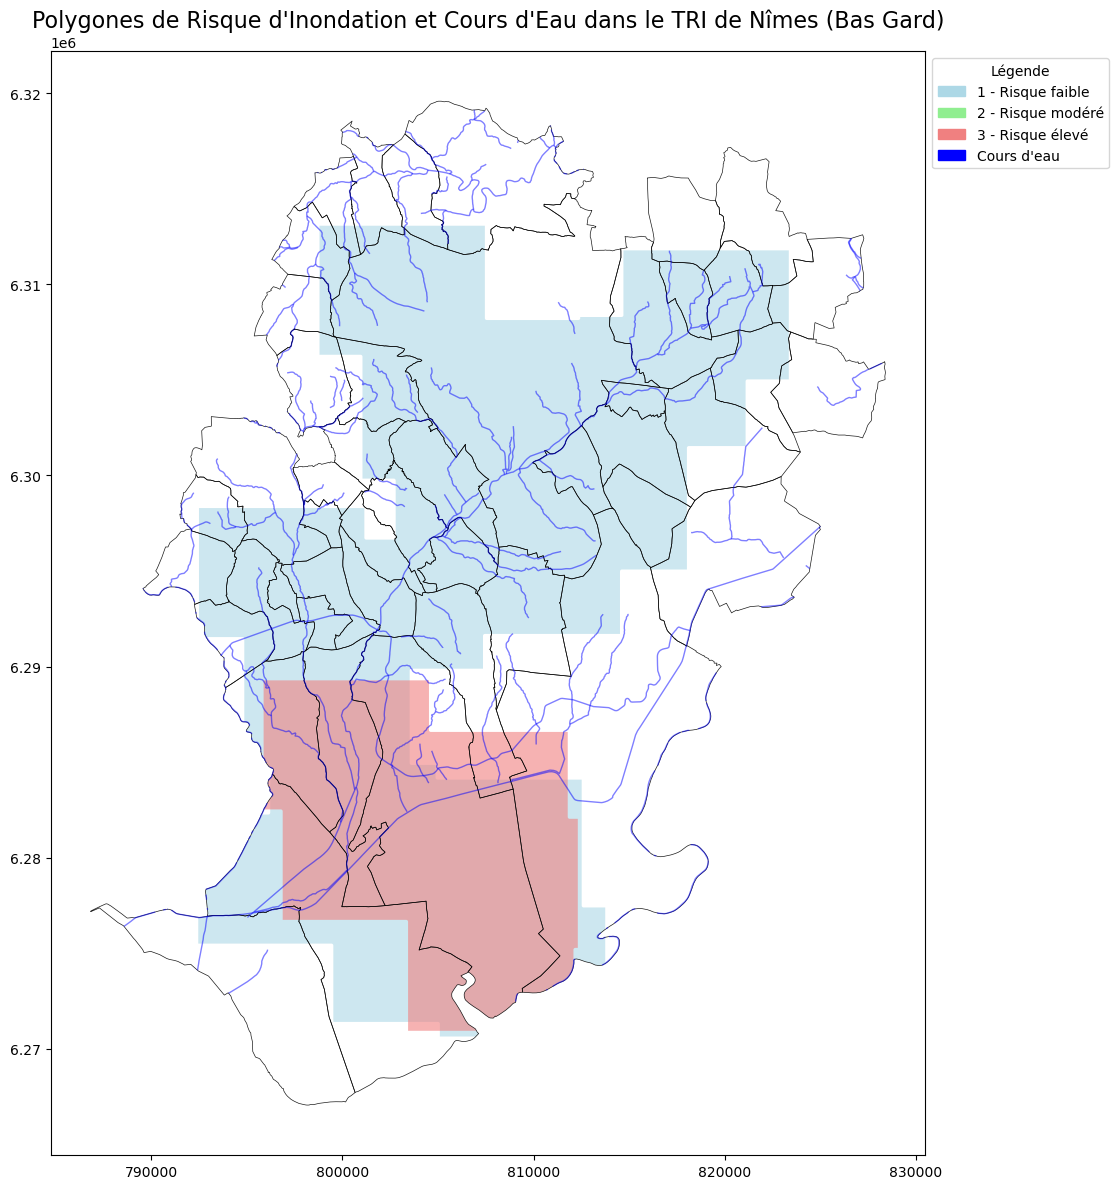

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download
import matplotlib.patches as mpatches

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_tri_nimes_carte_inond_s_030.shp"
gdf = gpd.read_file(shapefile_path)

# Reprojeter les géométries en un CRS projeté (EPSG:2154)
gdf = gdf.to_crs(epsg=2154)

# Télécharger le fond de carte Cartiflette pour le Gard
Gard = carti_download(
    crs=4326,
    values="30",
    borders="COMMUNE",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Reprojeter le crs de 'Gard' pour qu'il corresponde à celui de 'gdf' afin d'être dans le même référentiel géographique
Gard = Gard.to_crs(gdf.crs)

# Filtrer les communes du Gard pour ne garder que celles intersectant les polygones de 'gdf'
Gard_filtered = Gard[Gard.intersects(gdf.unary_union)]

# Découper les géométries des niveaux de risque d'inondation aux limites des communes sélectionnées
gdf_clipped = gpd.overlay(gdf, Gard_filtered, how="intersection")

# Prioriser les niveaux de risque pour réduire les superpositions
gdf_clipped['typ_inond1'] = gdf_clipped['typ_inond1'].astype(int)

# Dissoudre les polygones par niveau de risque pour réduire les fragments géométriques
gdf_dissolved = gdf_clipped.dissolve(by='typ_inond1')

# Lisser les bords avec un buffer positif puis négatif
gdf_dissolved['geometry'] = gdf_dissolved.buffer(100).buffer(-100)

# Charger les données des cours d'eau
waterways_path = "Shp file : Zones innondables/CoursEau_76_Occitanie.zip"
waterways = gpd.read_file(waterways_path)

# Reprojeter les cours d'eau pour correspondre au CRS des communes
waterways = waterways.to_crs(Gard_filtered.crs)

# Découper les cours d'eau aux limites des communes sélectionnées
waterways_clipped = gpd.overlay(waterways, Gard_filtered, how="intersection")

# Créer un dictionnaire de couleurs pour chaque type d'inondation
color_map = {
    1: "lightblue",   # Risque faible
    2: "lightgreen",  # Risque modéré
    3: "lightcoral",  # Risque élevé
}

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes filtrées
Gard_filtered.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.9)

# Ajouter les polygones des risques d'inondation avec les nouvelles couleurs et contours lissés
for risk_level, data in gdf_dissolved.groupby('typ_inond1'):
    data.plot(ax=ax, color=color_map[risk_level], alpha=0.6, label=f"Risque {risk_level}")

# Ajouter les cours d'eau tronqués
waterways_clipped.plot(ax=ax, color="blue", linewidth=1, alpha=0.5, label="Cours d'eau")

# Ajouter un titre
ax.set_title("Polygones de Risque d'Inondation et Cours d'Eau dans le TRI de Nîmes (Bas Gard)", fontsize=16)

# Ajouter une légende
legend_labels = ['1 - Risque faible', '2 - Risque modéré', '3 - Risque élevé']
legend_colors = ['lightblue', 'lightgreen', 'lightcoral']

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
patches.append(mpatches.Patch(color="blue", label="Cours d'eau"))  # Ajouter une légende pour les cours d'eau
ax.legend(handles=patches, title="Légende", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


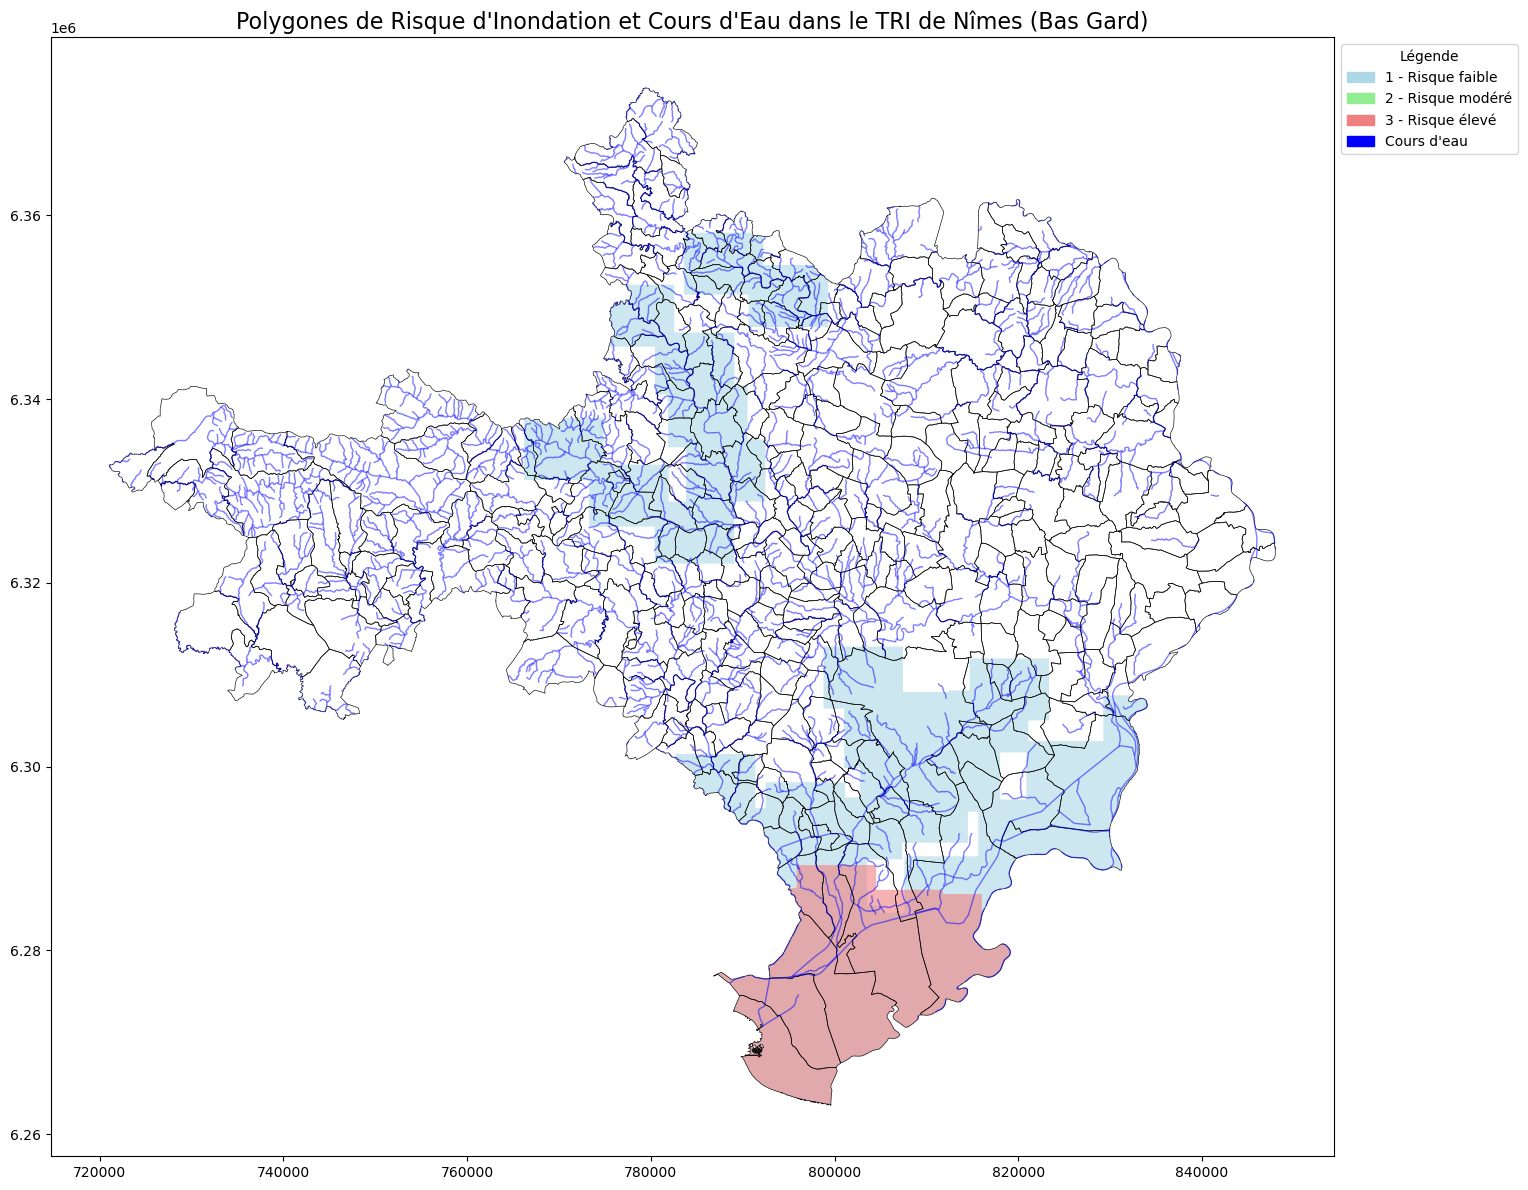

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download
import matplotlib.patches as mpatches

# Charger les données géographiques du Shapefile
# Liste des chemins vers les fichiers Shapefile
shapefile_paths = [
    "Shp file : Zones innondables/n_tri_nimes_carte_inond_s_030.shp",
    "Shp file : Zones innondables/n_tri_ales_carte_inond_s_030.shp",
    "Shp file : Zones innondables/n_tri_avignon_carte_inond_s_030.shp",
    "Shp file : Zones innondables/n_tri_delta_carte_inond_s_030.shp",
    "Shp file : Zones innondables/n_tri_montpellier_carte_inond_s_030.shp",
    "Shp file : Zones innondables/n_tri_nimes_carte_inond_s_030.shp"
   ]


# Charger et fusionner les fichiers Shapefile
gdfs = [gpd.read_file(shp) for shp in shapefile_paths]
gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# Reprojeter les géométries en un CRS projeté (EPSG:2154)
gdf = gdf.to_crs(epsg=2154)

# Télécharger le fond de carte Cartiflette pour le Gard
Gard = carti_download(
    crs=4326,
    values="30",
    borders="COMMUNE",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Reprojeter le crs de 'Gard' pour qu'il corresponde à celui de 'gdf' afin d'être dans le même référentiel géographique
Gard = Gard.to_crs(gdf.crs)

# Découper les géométries des niveaux de risque d'inondation aux limites des communes sélectionnées
gdf_clipped = gpd.overlay(gdf, Gard, how="intersection")

# Prioriser les niveaux de risque pour réduire les superpositions
gdf_clipped['typ_inond1'] = gdf_clipped['typ_inond1'].astype(int)

# Dissoudre les polygones par niveau de risque pour réduire les fragments géométriques
gdf_dissolved = gdf_clipped.dissolve(by='typ_inond1')

# Lisser les bords avec un buffer positif puis négatif
gdf_dissolved['geometry'] = gdf_dissolved.buffer(100).buffer(-100)

# Charger les données des cours d'eau
waterways_path = "Shp file : Zones innondables/CoursEau_76_Occitanie.zip"
waterways = gpd.read_file(waterways_path)

# Reprojeter les cours d'eau pour correspondre au CRS des communes
waterways = waterways.to_crs(Gard.crs)

# Découper les cours d'eau aux limites des communes sélectionnées
waterways_clipped = gpd.overlay(waterways, Gard, how="intersection")

# Créer un dictionnaire de couleurs pour chaque type d'inondation
color_map = {
    1: "lightblue",   # Risque faible
    2: "lightgreen",  # Risque modéré
    3: "lightcoral",  # Risque élevé
}

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes filtrées
Gard.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.9)

# Ajouter les polygones des risques d'inondation avec les nouvelles couleurs et contours lissés
for risk_level, data in gdf_dissolved.groupby('typ_inond1'):
    data.plot(ax=ax, color=color_map[risk_level], alpha=0.6, label=f"Risque {risk_level}")

# Ajouter les cours d'eau tronqués
waterways_clipped.plot(ax=ax, color="blue", linewidth=1, alpha=0.5, label="Cours d'eau")

# Ajouter un titre
ax.set_title("Risque d'Inondation dans le Gard)", fontsize=16)

# Ajouter une légende
legend_labels = ['1 - Risque faible', '2 - Risque modéré', '3 - Risque élevé']
legend_colors = ['lightblue', 'lightgreen', 'lightcoral']

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
patches.append(mpatches.Patch(color="blue", label="Cours d'eau"))  # Ajouter une légende pour les cours d'eau
ax.legend(handles=patches, title="Légende", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
